In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import IPython.display as ipd
from pathlib import Path

In [3]:
import torch
import librosa
import numpy as np
import pandas as pd

In [4]:
from fastai import *
from fastai.conv_learner import *
from fastai.core import *
from fastai.metrics import *
from fastai.text import SortSampler, SortishSampler
from data_loading_utils import read_file
from preprocessing_utils import load_features
from helpers import *
from metrics import *
from models import *

In [5]:
PATH = Path('../data/freesound')
TRAIN_PATH = PATH/'audio_train'
TRAIN_PATH_LMS = PATH/'audio_train_24000_1024_256_128'
# TRAIN_PATH_LMS_TFM = PATH/'audio_train_tfms_24000_1024_256_128'

TEST_PATH = PATH/'audio_test_24000'
TEST_PATH_LMS = PATH/'audio_test_24000_1024_256_128'

sample_rate = 24000
n_features = 128
n_fft = 1024
hop_length = 256

In [6]:
train_csv = pd.read_csv(PATH/'train.csv')
train_fname = train_csv.fname.values
test_csv = pd.read_csv(PATH/'sample_submission.csv')
test_fname = test_csv.fname.values

labels = sorted(train_csv.label.unique())
label_idx = {label:i for i, label in enumerate(labels)}

train_y = train_csv.label.apply(lambda l: label_idx[l]).values
test_y = np.zeros(len(test_fname))

len(train_fname), len(train_y), len(test_fname), len(test_y)

(9473, 9473, 9400, 9400)

In [7]:
stats = (-40.813029, 20.376415)

norm = Normalize(*stats)

# Commenting these transforms out because I didn't use them in the training data, because John said the tfms
# were not every effective anyway. So didn't want to slow down training for little gain.
# shift = RandomPitchTimeShift(min_x=1.0, max_x=1.0, max_y=1.2)
# light = RandomLight()

trn_tfms = Transforms([norm])
val_tfms = Transforms([norm])

In [8]:
((val_fname, trn_fname), (val_y, trn_y)) = get_first_split(train_fname, train_y, 7)
(len(trn_fname), len(trn_y), len(val_fname), len(val_y))

(8108, 8108, 1365, 1365)

In [9]:
num_classes = len(labels)
opt = optim.Adam
metrics = [accuracy, mapk]
loss = F.cross_entropy

In [10]:
bs = 16

In [11]:
trn_ds = AudioFilesDataset(TRAIN_PATH_LMS, trn_fname, trn_y, transform=trn_tfms)
trn_dl = AudioDataLoader2d(trn_ds,
                           batch_size=bs,
                           sampler=SortishSampler(trn_ds, key=lambda x: trn_ds[x][0].shape[1], bs=bs))

val_ds = AudioFilesDataset(TRAIN_PATH_LMS, val_fname, val_y, transform=val_tfms)
val_dl = AudioDataLoader2d(val_ds,
                           batch_size=bs,
                           sampler=SortSampler(val_ds, key=lambda x: val_ds[x][0].shape[1]))

aug_ds = AudioFilesDataset(TRAIN_PATH_LMS, val_fname, val_y, transform=trn_tfms)
aug_dl = AudioDataLoader2d(aug_ds,
                           batch_size=bs,
                           sampler=SortSampler(aug_ds, key=lambda x: aug_ds[x][0].shape[1]))

test_ds = AudioFilesDataset(TEST_PATH_LMS, test_fname, test_y, transform=val_tfms)
test_dl = AudioDataLoader2d(test_ds, batch_size=1)

test_aug_ds = AudioFilesDataset(TEST_PATH_LMS, test_fname, test_y, transform=trn_tfms)
test_aug_dl = AudioDataLoader2d(test_aug_ds, batch_size=1)

In [12]:
md = ModelData(PATH, trn_dl, val_dl, test_dl)
md.aug_dl = aug_dl
md.test_aug_dl = test_aug_dl

model = AudioResNet(BasicBlock, [4, 3, 2, 2], num_classes=num_classes).cuda()
learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

In [25]:
learn.lr_find()

 74%|███████▎  | 373/507 [02:38<00:56,  2.36it/s, loss=14.8]

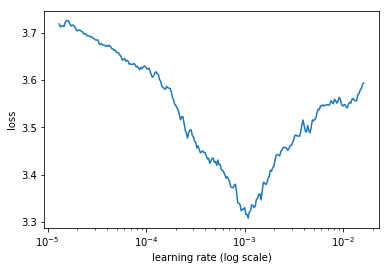

In [26]:
learn.sched.plot(n_skip_end=100)

In [14]:
lr = 5e-3
cycle_len = 30

In [27]:
learn.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=(5, 20, 0.95, 0.75))
# 3, 3, 3
learn.save_cycle('24khz_1024_256_128_modified', cycle_len)

  2%|▏         | 10/507 [00:08<07:01,  1.18it/s, loss=3.88] 
epoch      trn_loss   val_loss   accuracy   mapk            
    0      2.86489    2.872222   0.210256   0.308913  
    1      2.43501    2.600624   0.283516   0.394261        
    2      2.161972   2.49716    0.336264   0.463248        
    3      1.949103   2.323673   0.41978    0.531868        
    4      1.805257   2.559317   0.408791   0.517216        
    5      1.648214   2.139217   0.463004   0.574725        
    6      1.492186   2.00415    0.499634   0.592552        
    7      1.421329   1.983515   0.536264   0.632357        
    8      1.31266    1.95934    0.539194   0.63956         
    9      1.276139   2.17043    0.564103   0.655067        
    10     1.13345    1.785485   0.618315   0.697558        
    11     1.105233   1.777138   0.608059   0.702442        
    12     0.998307   1.894949   0.598535   0.692186         
    13     0.950323   1.784687   0.619048   0.708547         
    14     0.870296   1.6238

In [15]:
learn.load_cycle('24khz_1024_256_128_modified', cycle_len)

val_log_preds, val_targs = learn.predict_with_targs()
accuracy_np(val_log_preds, val_targs), mapk_np(val_log_preds, val_targs)

(0.7501831501831502, 0.7993894993894994)

In [16]:
val_aug_preds, val_aug_targs = learn.TTA()
preds = np.mean(val_aug_preds,0)
accuracy_np(preds, val_aug_targs), mapk_np(preds, val_aug_targs)

(0.7501831501831502, 0.7993894993894994)

### Using the transformed audio files

In [ ]:
trn_ds = AudioFilesDataset(TRAIN_PATH_LMS_TFM, trn_fname, trn_y, use_tfms=True, transform=trn_tfms)
trn_dl = AudioDataLoader2d(trn_ds,
                           batch_size=bs,
                           sampler=SortishSampler(trn_ds, key=lambda x: trn_ds[x][0].shape[1], bs=bs))

In [ ]:
md = ModelData(PATH, trn_dl, val_dl, test_dl)
md.aug_dl = aug_dl
md.test_aug_dl = test_aug_dl

model = AudioResNet(BasicBlock, [3, 3, 3], num_classes=num_classes).cuda()
learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

In [ ]:
learn.lr_find()
learn.sched.plot(n_skip_end=100)

In [ ]:
lr = 1e-3
cycle_len = 30

learn.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=(5, 20, 0.95, 0.75))
# 3, 3, 3
learn.save_cycle('24khz_1024_256_128_data_aug_2', cycle_len)

In [ ]:
learn.load_cycle('24khz_1024_256_128_data_aug_2', cycle_len)

val_log_preds, val_targs = learn.predict_with_targs()
accuracy_np(val_log_preds, val_targs), mapk_np(val_log_preds, val_targs)

In [ ]:
val_aug_preds, val_aug_targs = learn.TTA()
preds = np.mean(val_aug_preds,0)
accuracy_np(preds, val_aug_targs), mapk_np(preds, val_aug_targs)

In [ ]:
learn.load_cycle('24khz_1024_256_128_data_aug_2', cycle_len)

lr=1e-4
learn.fit(lr, 1, cycle_len=5, use_clr_beta=(5, 20, 0.95, 0.75))

In [ ]:
learn.load_cycle('24khz_1024_256_128_data_aug_2', cycle_len)


#### Predict results...

In [17]:
test_preds = learn.predict_with_targs(is_test=True)
predictions = test_preds[0]
predictions.shape

(9400, 41)

In [76]:
np.argmax(predictions, axis=1)

array([ 9, 18,  3, ...,  6,  3, 28])

In [70]:
np.array(labels)[np.argmax(predictions, axis=1)]

array(['Computer_keyboard', 'Flute', 'Bass_drum', ..., 'Cello', 'Bass_drum', 'Microwave_oven'], dtype='<U21')

In [52]:
test_fname

array(['00063640.wav', '0013a1db.wav', '002bb878.wav', ..., 'ffeba2cd.wav', 'fff6d073.wav', 'fff8d22d.wav'],
      dtype=object)

In [34]:
top_3 = np.array(labels)[np.argsort(-predictions, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test_csv.label = predicted_labels
test_csv.to_csv('24K_first_fold_1.csv', index=False)
test_csv.head()

,fname,label
0,00063640.wav,Computer_keyboard Scissors Shatter
1,0013a1db.wav,Flute Clarinet Violin_or_fiddle
2,002bb878.wav,Bass_drum Snare_drum Knock
3,002d392d.wav,Bass_drum Drawer_open_or_close Knock
4,00326aa9.wav,Oboe Telephone Tearing


In [63]:
test_csv.head()

,fname,label
0,00063640.wav,Computer_keyboard Scissors Shatter
1,0013a1db.wav,Flute Clarinet Violin_or_fiddle
2,002bb878.wav,Bass_drum Snare_drum Knock
3,002d392d.wav,Bass_drum Drawer_open_or_close Knock
4,00326aa9.wav,Oboe Telephone Tearing


In [72]:
def play_file(fname, path=TEST_PATH):
    fname = str(path/fname)
    print("playing", fname)
    return ipd.Audio(filename=fname, autoplay=True)

In [75]:
play_file('ffeba2cd.wav')

playing ../data/freesound/audio_test_24000/ffeba2cd.wav


In [ ]:
test_preds_multi = learn.TTA(is_test=True)

In [ ]:
test_preds_multi[0].shape

In [ ]:
test_preds2 = np.mean(test_preds_multi[0],0)

In [ ]:
test_preds2.shape

In [ ]:
top_3 = np.array(labels)[np.argsort(-test_preds2, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test_csv.label = predicted_labels
test_csv.to_csv('24K_first_fold_1_TTA.csv', index=False)
test_csv.head()

### Pseudo Labeling

In [82]:
def get_ds_and_dl(path, fnames, labels, tfms, bs):    
    ds = AudioFilesDataset(path, fnames, labels, transform=tfms)
    dl = AudioDataLoader2d(ds, batch_size=bs, sampler=SortishSampler(ds, key=lambda x: ds[x][0].shape[1], bs=bs))
    return (ds, dl)

In [79]:
def get_pseudo_labels(learn):
    test_preds = learn.predict_with_targs(is_test=True)
    predictions = test_preds[0]
    label_indexes = np.argmax(predictions, axis=1)
    return label_indexes

In [ ]:
def train_with_pseudo_data(pseudo_dl, val_dl, existing_weights):
    md = ModelData(PATH, pseudo_dl, val_dl)
    model = AudioResNet(BasicBlock, [4, 3, 2, 2], num_classes=num_classes).cuda()
    learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)
    learn.load_cycle(existing_weights, 30)
    lr=1e-4
    cycle_len = 5
    learn.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=(5, 20, 0.95, 0.75))
    learn.save_cycle('24khz_1024_256_128_psuedo_label', cycle_len)

In [80]:
pseudo_labels = get_pseudo_labels(learn)

In [84]:
pseudo_label_ds, pseudo_label_dl = get_ds_and_dl(TEST_PATH_LMS, list(test_fname), pseudo_labels, trn_tfms, bs)

In [91]:
train_with_pseudo_data(pseudo_label_dl, val_dl, '24khz_1024_256_128_modified')

epoch      trn_loss   val_loss   accuracy   mapk             
    0      1.073045   2.35488    0.738462   0.790598  
    1      0.878049   2.123129   0.730403   0.785226         
    2      0.910913   2.01331    0.725275   0.78315          
    3      0.649743   2.18312    0.723077   0.780952         
    4      0.615259   2.151446   0.720147   0.777167         



In [92]:
val_log_preds, val_targs = learn.predict_with_targs()
accuracy_np(val_log_preds, val_targs), mapk_np(val_log_preds, val_targs)

(0.7501831501831502, 0.7993894993894994)

#### Try creating multiple models with different subsets of training data, ensemble results

In [ ]:
bs = 16
n_folds = 5
lr = 1e-3
cycle_len = 50

for i, val_idx in enumerate(get_val_idx(train_y, n_folds=n_folds)):
    ((val_fname, trn_fname), (val_y, trn_y)) = get_trn_val_split_from_folds(train_fname, train_y, val_idx)
    
    print('Fold', i+1)
    
    if i < 4:
        continue
    
    trn_ds = AudioFilesDataset(TRAIN_PATH_LMS_TFM, trn_fname, trn_y, use_tfms=True, transform=trn_tfms)
    trn_dl = AudioDataLoader2d(trn_ds,
                               batch_size=bs,
                               sampler=SortishSampler(trn_ds, key=lambda x: trn_ds[x][0].shape[1], bs=bs))

    val_ds = AudioFilesDataset(TRAIN_PATH_LMS, val_fname, val_y, transform=val_tfms)
    val_dl = AudioDataLoader2d(val_ds,
                               batch_size=bs,
                               sampler=SortSampler(val_ds, key=lambda x: val_ds[x][0].shape[1]))

    md = ModelData(PATH, trn_dl, val_dl)
    model = AudioResNet(BasicBlock, [2, 3, 3], num_classes=num_classes).cuda()
    learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)
    
    fn = f'24Khz_1024_256_128_fold_{i}'
    print(f'Starting fold: {fn} at {datetime.datetime.now()}')
        
    learn.fit(lr, 1, cycle_len=cycle_len, use_clr_beta=(5, 20, 0.95, 0.75))
    print('Ending: ', datetime.datetime.now())
    print('-----')

    learn.save_cycle(fn, cycle_len)

In [ ]:
md = ModelData(PATH, trn_dl, val_dl, test_dl)
model = AudioResNet(BasicBlock, [2, 3, 3], num_classes=num_classes).cuda()
learn = ConvLearner.from_model_data(model, md, crit=loss, metrics=metrics, opt_fn=opt)

n_folds = 5
all_preds = []
for i in range(n_folds):
    print('Predicting fold:', i)
    weights_file = f'24Khz_1024_256_128_fold_{i}'
    learn.load_cycle(weights_file, 50)
    model_preds = learn.predict_with_targs(is_test=True)[0]
    all_preds.append(model_preds)

In [ ]:
final_pred = np.ones_like(all_preds[0])
for p in all_preds:
    final_pred *= np.exp(p / 10)
final_pred = final_pred**(1./len(all_preds))
final_pred.shape

In [ ]:
top_3 = np.array(labels)[np.argsort(-final_pred, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test_csv.label = predicted_labels
test_csv.to_csv('24k_1024_256_128_all_folds.csv', index=False)
test_csv.head(10)